https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/#h2_7

https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa

# Image Caption Generation with Attention Mechanism in TensorFlow

---

## Introduction

The attention mechanism is a complex cognitive ability that human beings possess. When people receive information, they can consciously ignore some of the main information while ignoring other secondary information.

This ability of self-selection is called attention. The attention mechanism allows the neural network to have the ability to focus on its subset of inputs to select specific features. 

The model architecture used here is based on the TensorFlow [tutorial](https://www.tensorflow.org/tutorials/text/image_captioning) and inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder.

## Problem Statement

We want to generate captions for fun.

## Setup

---

We will be leveraging Google Colab for our training, so we'll need to prepare the environment and ensure the necessary packages are installed.

Once done, we can import the required libraries we will be using.

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 19 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 135 MB in 13s (10.5 MB/s)
(Reading database ... 124016 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 t

In [2]:
!pip uninstall -y tensorflow keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [3]:
!pip install -U tensorflow_text==2.11.0 tensorflow==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


In [4]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached einops-0.6.0-py3-none-any.whl (41 kB)


In [5]:
import string
import numpy as np
import einops
import matplotlib.pyplot as plt
import random
import sys
import time
import os
import re
import collections
import warnings

warnings.filterwarnings("ignore")


import tensorflow as tf
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import load_img

In [6]:
if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
rng = 42
tf.keras.utils.set_random_seed(rng)

batch_size = 32
buffer_size = 5000

if os.getenv("COLAB_RELEASE_TAG"):
    workspace_path = "/content/drive/MyDrive/Capstone/"
else:
    workspace_path = os.getcwd()

assets_path = os.path.join(workspace_path, "flickr30k")
images_path = os.path.join(assets_path, "flickr30k_images")
captions_path = os.path.join(assets_path, "captions.txt")
model_path = os.path.join(workspace_path, "model")
checkpoint_path = '/tmp/checkpoint'

## Prepare the Data

---

There are various datasets that are suitable for our training, but I will be utilising the [Flickr30k](https://shannon.cs.illinois.edu/DenotationGraph/) dataset in this project, a popular dataset for use with image caption generation. The dataset consists of 158,915 crowd-sourced captions describing 31,783 images.

I've hosted the dataset in [Kaggle](https://www.kaggle.com/datasets/eeshawn/flickr30k), so feel free to access and utilise the dataset for use in your projects.

Other datasets to consider include Microsoft's [COCO](https://cocodataset.org/) dataset or Google's [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/).

In [8]:
with open(captions_path, encoding="utf8") as f:
    data_raw = [line.rstrip("\n") for line in f.readlines()]
    data_dict = {}
    for line in data_raw[1:]:
        image_name, _, caption = line.split(",")
        if image_name not in data_dict:
            data_dict[image_name] = []
        data_dict[image_name].append(caption)

print(f"Total Images in Dataset = {len(data_dict)}")

Total Images in Dataset = 31783


Based on the images that are in the dataset, let's have a sense of what type of captions are included.

In [9]:
def get_captions(image:str) -> list:    
    captions = data_dict[image]
    return list(captions)

def check_random_sample(n:int):
    if n <= 0:
        raise ValueError("n must be greater than 0")
    elif type(n) != int:
        raise TypeError("n must be an integer")

    fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(10,n*4), squeeze=False)
    image_samples = random.sample(data_dict.keys(), n)
    for idx, image in enumerate(image_samples):
        filepath = os.path.join(images_path, image)
        image_load = load_img(filepath)
        ax[idx, 0].imshow(image_load)
        ax[idx, 0].axis("off")
        ax[idx, 0].set_title(image, fontsize=20)
        captions = get_captions(image)
        ax[idx, 1].set_ylim(0, len(captions))
        for i, caption in enumerate(captions):
            ax[idx, 1].text(0, i+0.25, caption, fontsize=20)
            ax[idx, 1].axis("off")
    
    fig.tight_layout()
    plt.show()

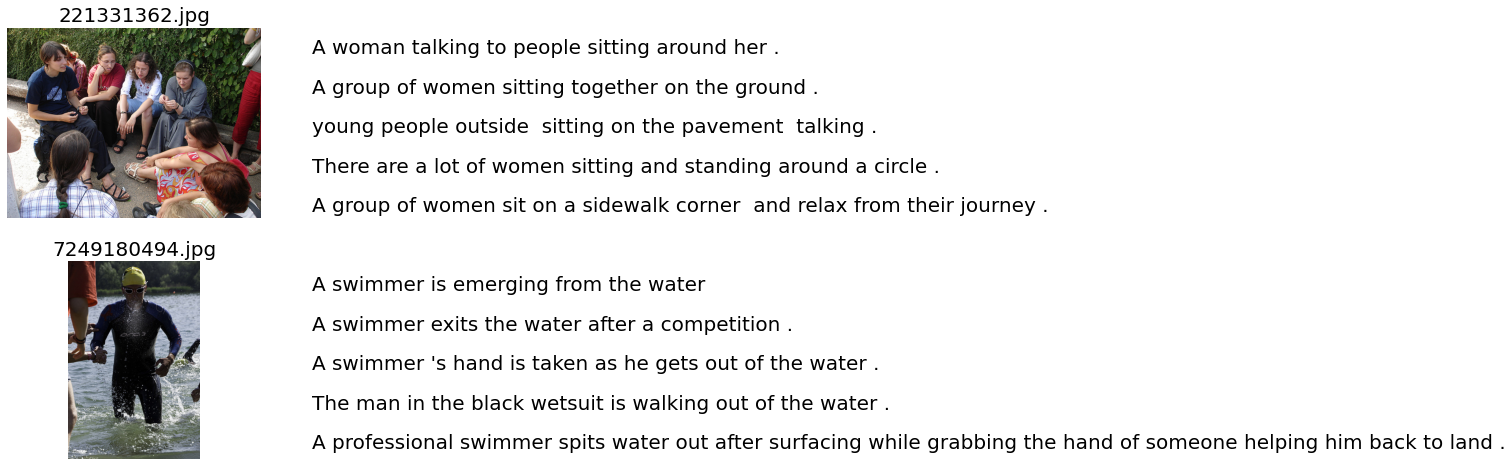

In [67]:
check_random_sample(2)

In [12]:
min_length = 100
max_length = 0

for captions in data_dict.values():
    for caption in captions:
        caption_length = len(caption.split())
        if caption_length < min_length:
            min_length = caption_length
        if caption_length > max_length:
            max_length = caption_length

print(f"The shortest caption has {min_length} words and the longest caption has {max_length} words")

79


Using a function that retrieves and displays random samples from our dataset, we verify that there are 5 captions for each image of varying lengths, each describing the scene in different levels of details.

We will next prepare our dataset in the TensorFlow dataset format to better optimise our training workflow with a data pipeline. As part of the function, I have also included an option to limit the `sample_size` if needed, as well as specify how to split our train and validation data sets.

In [13]:
## generate train and test datasets
def generate_dataset(data: dict, test_size: float, sample_size: int=None):
    if sample_size:
        max_keys = random.sample(data.keys(), sample_size)
        sample_size = int(test_size * sample_size)
        test_keys = random.sample(max_keys, sample_size)
        train_keys = [key for key in max_keys if key not in test_keys]
    else:
        sample_size = int(test_size * len(data))
        test_keys = random.sample(data.keys(), sample_size)
        train_keys = [key for key in data.keys() if key not in test_keys]
    
    test_captions = [(os.path.join(images_path, key), val) for key, val in data.items() if key in test_keys]
    train_captions = [(os.path.join(images_path, key), val) for key, val in data.items() if key in train_keys]
    print(f"Data split into {len(train_captions)} samples in train, {len(test_captions)} samples in test")

    train_raw = tf.data.experimental.from_list(train_captions)
    test_raw = tf.data.experimental.from_list(test_captions)
    return train_raw, test_raw

In [14]:
sample_size = 25000
test_size = 0.2

train_raw, test_raw = generate_dataset(data_dict, test_size, sample_size)

Data split into 20000 samples in train, 5000 samples in test


Extracting one sample from our dataset, we see that it consists of an image path together with the 5 captions.

In [15]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/Capstone/flickr30k/flickr30k_images/1000092795.jpg', shape=(), dtype=string)
tf.Tensor(
[b'Two young guys with shaggy hair look at their hands while hanging out in the yard .'
 b'Two young  White males are outside near many bushes .'
 b'Two men in green shirts are standing in a yard .'
 b'A man in a blue shirt standing in a garden .'
 b'Two friends enjoy time spent together .'], shape=(5,), dtype=string)


## Image Feature Extraction

---

Using transfer learning with a pre-trained image classifier model, we can extract the features from our images. Since we are not trying to perform classification, `include_top=False` returns the model without the classification layer and allows us to extract the feature maps.

## Why use MobileNet?

The MobileNet model that we are using works with images that are of 224 x 224 pixels, so we will create a function to load and resize our images appropriately.

In [16]:
image_shape = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV3Small(
    include_top=False,
    include_preprocessing=True,
    input_shape=image_shape,
)

# Freeze the base_model
base_model.trainable = False

4334752/4334752 [==============================] - 0s 0us/step


In [17]:
# function to load and resize image
def load_image(image_path):

    def parse(s):
        return s
    
    image_path = tf.py_function(parse, [image_path], (tf.string))
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

In [18]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(base_model(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


## Set Up Tokenizer

---

Using a TextVectorization layer, we will create a tokenizer that transform our text captions into integer sequences.

- Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
- Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to the `max_length` of our captions.
- Create word-to-index and index-to-word mappings to display results.

In [19]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [20]:
# Use the top 8,000 words for a vocabulary.
vocabulary_size = 8000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True
    )

In [21]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [22]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

Using the `test_caption` below, the tokenizer converts the caption into a sequence of integers. Using the word_to_index and index_to_word mappings, we can convert the eventual output of our model back into text.

In [23]:
test_caption = 'Two young guys with shaggy hair look at their hands while hanging out in the yard .'

In [24]:
caption_0_token = tokenizer(test_caption)
print(caption_0_token)

tf.Tensor(
[   3   14   21  316   12 2089  111  187   18   63  159   25  347   72
    5    6  496    4], shape=(18,), dtype=int64)


In [25]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [26]:
caption_0_word = index_to_word(caption_0_token)
tf.strings.reduce_join(caption_0_word, separator=' ', axis=-1).numpy()

b'[START] two young guys with shaggy hair look at their hands while hanging out in the yard [END]'

## Prepare Our Datasets

---

Currently, our train_raw and test_raw datasets contain 1:many (image, captions) pairs, which we will need to convert into 1:1 for training.

In [31]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [32]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [33]:
def prepare_dataset(ds, tokenizer, batch_size=batch_size, shuffle_buffer=buffer_size):
  # Load the images and make batches.
  ds = (ds
        .shuffle(shuffle_buffer)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.Dataset.ignore_errors)
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [34]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [35]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions save_dataset and load_dataset:

In [36]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=batch_size):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.Dataset.ignore_errors)
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(buffer_size))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

In [37]:
def load_dataset(save_path, batch_size=batch_size, shuffle=buffer_size, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(buffer_size)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [38]:
save_dataset(train_raw, 'train_cache', base_model, tokenizer)
save_dataset(test_raw, 'test_cache', base_model, tokenizer)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Good reading on buffer size

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

# Check that we are optimising for GPU / TPU processing in Colab

- https://colab.research.google.com/notebooks/tpu.ipynb
- https://www.tensorflow.org/guide/distributed_training#tpustrategy

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. 

https://keras.io/guides/transfer_learning/

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
1. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
1. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
1. Train the new layers on your dataset.

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting include_top=False returns the model without the final classification layer, so you can use the last layer of feature-maps:

In [39]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [40]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [41]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [42]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


In [43]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [44]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


In [45]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [48]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [49]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/3125 [00:00<?, ?it/s]


Uniform entropy: 8.99
Marginal entropy: 5.56


In [50]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=max_length, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [51]:
@Captioner.add_method
def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
        # Apply the feature-extractor, if you get an RGB image.
        image = self.feature_extractor(image)
    
        # Flatten the feature map
        image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
        # Apply the tokenizer if you get string inputs.
        txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
        txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [52]:
model = Captioner(tokenizer, feature_extractor=base_model, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [53]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

## Train

In [54]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

## Callbacks

In [55]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [56]:
early_stop = tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)

save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='masked_acc',
        mode='max',
        verbose=1,
        initial_value_threshold=0.3,
        save_best_only=True)

In [57]:
callbacks = [
    GenerateText(),
    early_stop,
    save_checkpoint
    ]

64400/64400 [==============================] - 0s 0us/step


In [58]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [59]:
steps = (sample_size * (1 - test_size)) / batch_size

history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=steps,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 4.7761 - masked_acc: 0.2482

a man in a blue shirt is sitting on a blue shirt is sitting on the water
a man in a white shirt is holding a a green shirt and a black beach
a group of a field of going in the head shirt on the side of road running during the angle a boat


Epoch 1: masked_acc did not improve from 0.30000
625/625 [==============================] - 667s 1s/step - loss: 4.7761 - masked_acc: 0.2482 - val_loss: 4.3512 - val_masked_acc: 0.2882
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 4.2221 - masked_acc: 0.2999

a man in a blue shirt is playing in the water
a man is riding a water while a water
a stage standing decorated in the deck pieces of mouth through the rain holds a wave


Epoch 2: masked_acc did not improve from 0.30000
625/625 [==============================] - 638s 1s/step - loss: 4.2221 - masked_acc: 0.2999 - val_loss: 4.0054 - val_masked_acc: 0.3129
Epoch 3/100
625/62

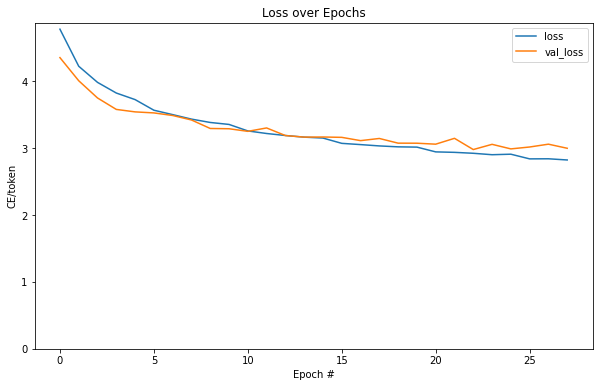

In [79]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.title('Loss over Epochs')
plt.legend()

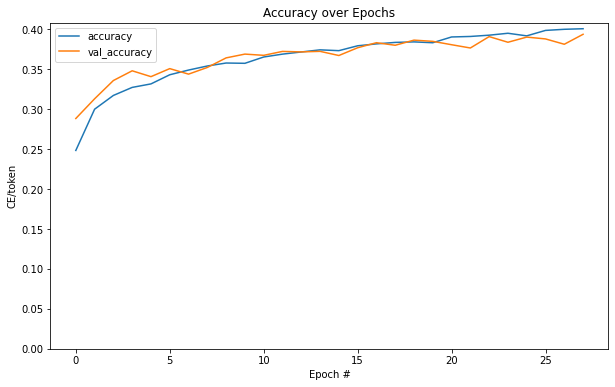

In [72]:
plt.figure(figsize=(10,6))
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.title('Accuracy over Epochs')
plt.legend()

In [62]:
# model.save(model_path)

In [63]:
model.save_weights(model_path+"/trained_model")

In [64]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):

    def plot_attention_maps(image, str_tokens, attention_map):
        fig = plt.figure(figsize=(16, 9))

        len_result = len(str_tokens)
        
        titles = []
        for i in range(len_result):
            map = attention_map[i]
            grid_size = max(int(np.ceil(len_result/2)), 2)
            ax = fig.add_subplot(3, grid_size, i+1)
            titles.append(ax.set_title(str_tokens[i]))
            img = ax.imshow(image)
            ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                        clim=[0.0, np.max(map)])
            plt.axis("off")

        plt.tight_layout()

    result_txt = self.simple_gen(image, temperature)
    str_tokens = result_txt.split()
    str_tokens.append('[END]')

    attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
    attention_maps = tf.concat(attention_maps, axis=0)
    attention_maps = einops.reduce(
        attention_maps,
        'batch heads sequence (height width) -> sequence height width',
        height=7, width=7,
        reduction='mean')

    plot_attention_maps(image/255, str_tokens, attention_maps)
    t = plt.suptitle(result_txt)
    t.set_y(1.05)


45242/45242 [==============================] - 0s 0us/step


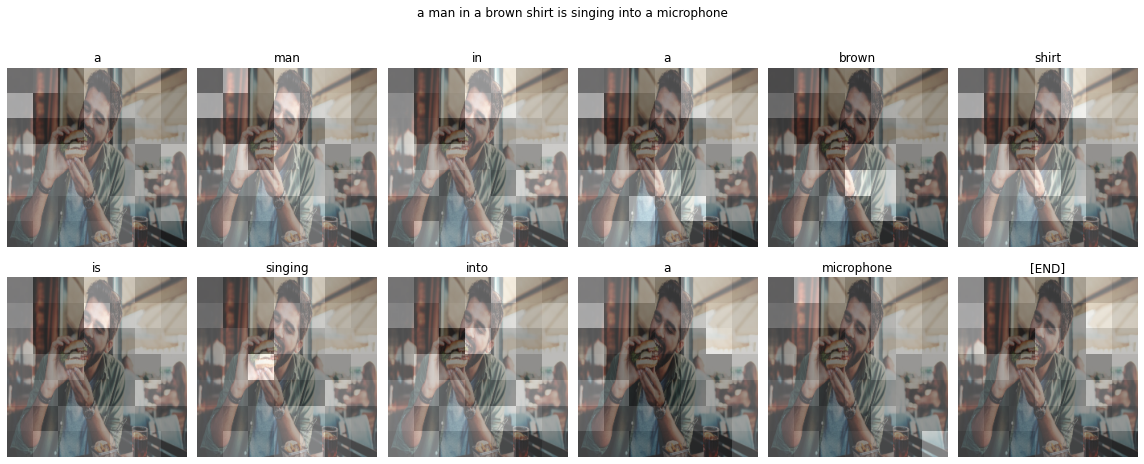

In [65]:
image_url = 'https://media.istockphoto.com/id/1045043934/photo/breakfast-in-a-cafe-food-lifestyle-concept.jpg?s=612x612&w=0&k=20&c=3LgAgp7S_1C5aX0mk94MmbmLQbi2W0z2MBN11wZo2M8='
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)